In [1]:
%load_ext autoreload
%autoreload 2
import os

os.chdir("/home/jorge/thesis")

from text3d2video.pipelines.texgen_pipeline import TexGenLogic
import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texgen_pipeline import TexGenPipeline
from diffusers.schedulers import DDIMScheduler

In [2]:
device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(TexGenPipeline, sd_repo, controlnet_repo, DDIMScheduler)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
texgen = TexGenLogic(pipe, 600, 7.5, 1.0, [])

In [9]:
import numpy as np
from text3d2video.util import read_obj_with_uvs
from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
mesh, verts_uvs, faces_uvs = read_obj_with_uvs(mesh_path, device=device)

n_frames = 8
dist = 5.8

angles = np.linspace(0, 360, n_frames, endpoint=False)
R, T = turntable_extrinsics(dists=dist, angles=angles)
frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
prompt_suffixes = [f", {cam_view_prompt(a, 0)} view" for a in angles]
frame_meshes = mesh.extend(len(frame_cams))

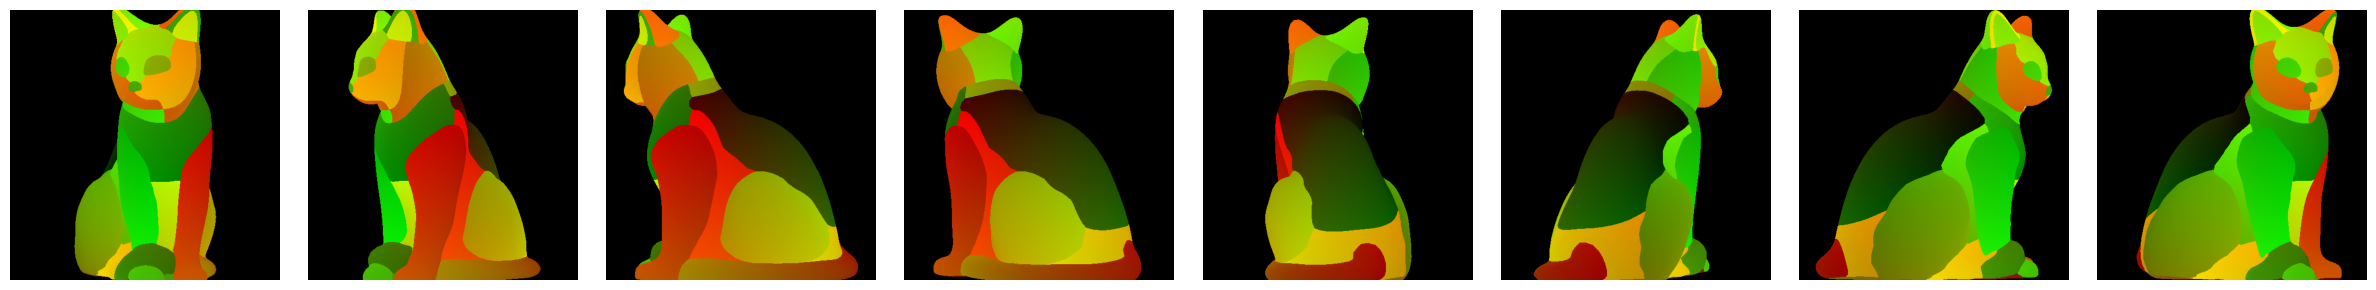

In [10]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_ims

uv_renders = render_rgb_uv_map(frame_meshes, frame_cams, verts_uvs, faces_uvs)

display_ims(uv_renders)

In [14]:
# precompute rasterization and projections
from text3d2video.backprojection import project_visible_texels_to_camera
from text3d2video.rendering import make_mesh_rasterizer

image_res = 512

projections = []
fragments = []
rasterizer = make_mesh_rasterizer(resolution=image_res)
for i in range(n_frames):
    cam = frame_cams[i]
    mesh = frame_meshes[i]

    # project UVs to camera
    projection = project_visible_texels_to_camera(
        mesh,
        cam,
        verts_uvs,
        faces_uvs,
        texture_res=texgen.uv_res,
        raster_res=2000,
    )
    projections.append(projection)

    # rasterize
    frags = rasterizer(frame_meshes[i], cameras=frame_cams[i])
    fragments.append(frags)